<a href="https://colab.research.google.com/github/Patternic10/CSCI-4170-Project-in-AI-ML/blob/main/Homework6_rcs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/home/kazeej/anaconda3/envs/recsys/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Missing values:
 user_id      0
item_id      0
rating       0
timestamp    0
dtype: int64

Dataset Info:
            user_id        item_id         rating     timestamp
count  100000.00000  100000.000000  100000.000000  1.000000e+05
mean      462.48475     425.530130       3.529860  8.835289e+08
std       266.61442     330.798356       1.125674  5.343856e+06
min         1.00000       1.000000       1.000000  8.747247e+08
25%       254.00000     175.000000       3.000000  8.794487e+08
50%       447.00000     322.000000       4.000000  8.828269e+08
75%       682.00000     631.000000       4.000000  8.882600e+08
max       943.00000    1682.000000       5.000000  8.932866e+08

Number of Users: 943
Number of Items: 1682


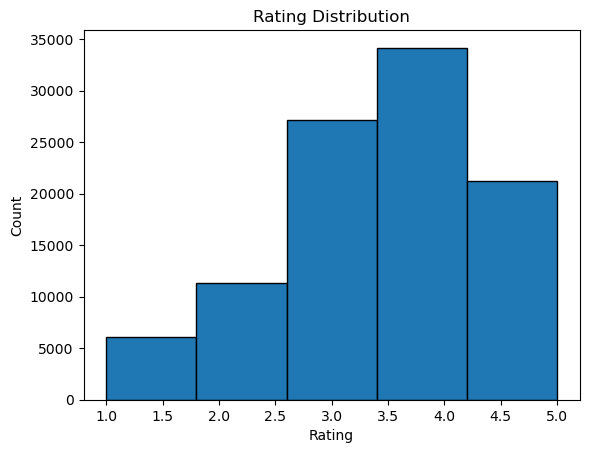

In [ ]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split as surprise_split
from implicit.als import AlternatingLeastSquares
import implicit

# Step 1: Load and Clean Data
url = "https://files.grouplens.org/datasets/movielens/ml-100k/u.data"
columns = ['user_id', 'item_id', 'rating', 'timestamp']
data = pd.read_csv(url, sep='\t', names=columns)

# Check for missing values
print("Missing values:\n", data.isnull().sum())
# No missing values expected in MovieLens 100k, but drop if any
data = data.dropna()

# Step 2: Exploratory Data Analysis (EDA)
print("\nDataset Info:")
print(data.describe())
print("\nNumber of Users:", data['user_id'].nunique())
print("Number of Items:", data['item_id'].nunique())

# Rating distribution
plt.hist(data['rating'], bins=5, edgecolor='black')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()



In [ ]:
# User and item activity
user_counts = data['user_id'].value_counts()
item_counts = data['item_id'].value_counts()
print("\nAverage ratings per user:", user_counts.mean())
print("Average ratings per item:", item_counts.mean())

# Step 3: Convert to User-Item Matrix
user_item_df = data.pivot(index='user_id', columns='item_id', values='rating').fillna(0)
user_item_matrix = csr_matrix(user_item_df.values)
print("\nUser-Item Matrix Shape:", user_item_matrix.shape)
sparsity = 1 - (data.shape[0] / (user_item_df.shape[0] * user_item_df.shape[1]))
print("Sparsity:", f"{sparsity:.4f}")

# Step 4: Train-Test Split for Manual Evaluation
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)




Average ratings per user: 106.04453870625663
Average ratings per item: 59.45303210463734

User-Item Matrix Shape: (943, 1682)
Sparsity: 0.9370


In [ ]:
# Algorithm 1: Matrix Factorization with SVD (using Surprise)
reader = Reader(rating_scale=(1, 5))
surprise_data = Dataset.load_from_df(data[['user_id', 'item_id', 'rating']], reader)
trainset, testset = surprise_split(surprise_data, test_size=0.2, random_state=42)

svd = SVD(n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02, random_state=42)
svd.fit(trainset)
svd_predictions = svd.test(testset)
svd_rmse = accuracy.rmse(svd_predictions)

# Precision@k for SVD
def precision_at_k(predictions, k=10, threshold=4.0):
    user_est_true = {}
    for uid, _, true_r, est, _ in predictions:
        if uid not in user_est_true:
            user_est_true[uid] = []
        user_est_true[uid].append((est, true_r))

    precisions = []
    for uid, ratings in user_est_true.items():
        ratings.sort(key=lambda x: x[0], reverse=True)
        top_k = ratings[:k]
        n_relevant = sum(1 for est, true in top_k if true >= threshold)
        precisions.append(n_relevant / k if k > 0 else 0)
    return np.mean(precisions)

svd_precision = precision_at_k(svd_predictions, k=10)
print(f"\nSVD RMSE: {svd_rmse:.4f}")
print(f"SVD Precision@10: {svd_precision:.4f}")




RMSE: 0.9352

SVD RMSE: 0.9352
SVD Precision@10: 0.5837


In [ ]:
# Algorithm 2: Alternating Least Squares (using implicit, CPU-only)
# Define full dimensions based on entire dataset
n_users = data['user_id'].nunique()  # 943
n_items = data['item_id'].nunique()  # 1682

# Create sparse training matrix with full dimensions
train_users = train_data['user_id'].values - 1
train_items = train_data['item_id'].values - 1
train_ratings = train_data['rating'].values
train_matrix = csr_matrix((train_ratings, (train_users, train_items)), shape=(n_users, n_items))

als = AlternatingLeastSquares(factors=100, regularization=0.01, iterations=20, use_gpu=False)
als.fit(train_matrix)

# Predict ratings for test set
def als_predict(als_model, test_data, n_users, n_items):
    predictions = []
    for _, row in test_data.iterrows():
        user = int(row['user_id']) - 1
        item = int(row['item_id']) - 1
        # Check bounds to avoid IndexError
        if user < n_users and item < n_items:
            pred = np.dot(als_model.user_factors[user], als_model.item_factors[item])
            pred = min(max(pred, 1), 5)  # Clip to rating scale
        else:
            pred = 3.0  # Default prediction (mean rating) for unseen users/items
        predictions.append(pred)
    return predictions

als_predictions = als_predict(als, test_data, n_users, n_items)
als_rmse = np.sqrt(mean_squared_error(test_data['rating'], als_predictions))

# Precision@k for ALS
def als_precision_at_k(als_model, test_data, n_users, n_items, k=10, threshold=4.0):
    user_preds = {}
    for _, row in test_data.iterrows():
        uid = int(row['user_id'])
        iid = int(row['item_id'])
        true_r = row['rating']
        if (uid - 1) < n_users and (iid - 1) < n_items:
            pred = min(max(np.dot(als_model.user_factors[uid-1], als_model.item_factors[iid-1]), 1), 5)
        else:
            pred = 3.0  # Default for unseen
        if uid not in user_preds:
            user_preds[uid] = []
        user_preds[uid].append((pred, true_r))

    precisions = []
    for uid, ratings in user_preds.items():
        ratings.sort(key=lambda x: x[0], reverse=True)
        top_k = ratings[:k]
        n_relevant = sum(1 for est, true in top_k if true >= threshold)
        precisions.append(n_relevant / k if k > 0 else 0)
    return np.mean(precisions)

als_precision = als_precision_at_k(als, test_data, n_users, n_items, k=10)
print(f"\nALS RMSE: {als_rmse:.4f}")
print(f"ALS Precision@10: {als_precision:.4f}")


100%|██████████| 20/20 [12:58<00:00, 38.92s/it]



ALS RMSE: 2.7622
ALS Precision@10: 0.4835

Performance Comparison:
SVD - RMSE: 0.9352, Precision@10: 0.5837
ALS - RMSE: 2.7622, Precision@10: 0.4835


In [ ]:
# Step 5: Comparison
print("\nPerformance Comparison:")
print(f"SVD - RMSE: {svd_rmse:.4f}, Precision@10: {svd_precision:.4f}")
print(f"ALS - RMSE: {als_rmse:.4f}, Precision@10: {als_precision:.4f}")


Performance Comparison:
SVD - RMSE: 0.9352, Precision@10: 0.5837
ALS - RMSE: 2.7622, Precision@10: 0.4835


E. Zangerle and C. Bauer, “Evaluating Recommender Systems: Survey and Framework,” ACM Comput. Surv., vol. 55, no. 8, pp. 1–38, Aug. 2023.